In [1]:
import numpy as np
import os
import fitsio as fi
from matplotlib import rcParams
import matplotlib.pyplot as plt
#plt.style.use('y1a1')
from scipy.interpolate import interp1d, interp2d
import sys


rcParams['xtick.major.size'] = 3.5
rcParams['xtick.minor.size'] = 1.7
rcParams['ytick.major.size'] = 3.5
rcParams['ytick.minor.size'] = 1.7

np.random.seed(98765)

base = '%s/../'%os.getcwd()

In [2]:
# to begin, let's just read in the file
sample_name='paus_all_fields_bright_red_zb_equip_3_bins_2'
filename = '2pt_%s.fits'%sample_name
f = fi.FITS(filename)

In [3]:
f


  file: 2pt_paus_all_fields_bright_red_zb_equip_3_bins_2.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      nz_paus_all_fields_bright_red_zb_equip_3_bins_2_shape
  2      BINARY_TBL      nz_paus_all_fields_bright_red_zb_equip_3_bins_2_density
  3      BINARY_TBL      wgp
  4      BINARY_TBL      wgg
  5      IMAGE_HDU       COVMAT

In [4]:
### redshift distributions

# when we read in a HDU, it becomes a structured array
info_nz_s = f['nz_%s_shape'%sample_name].read()
info_nz_d = f['nz_%s_density'%sample_name].read()

# print out the column names -- basically it's just the z sampling + the value of the n(z)
print(info_nz_s.dtype.names)

('Z_MID', 'Z_LOW', 'Z_HIGH', 'BIN1')


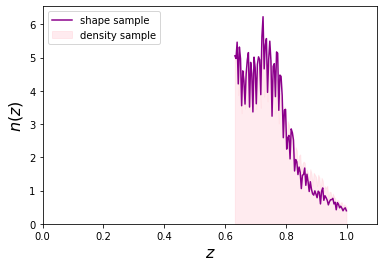

In [5]:
# here's what they look like
plt.plot(info_nz_s['Z_MID'],info_nz_s['BIN1'], color='darkmagenta', label='shape sample')
plt.fill_between(info_nz_d['Z_MID'],info_nz_d['BIN1'], color='pink', alpha=0.3, label='density sample')

plt.xlabel('$z$', fontsize=16)
plt.ylabel('$n(z)$', fontsize=16)
plt.xlim(0,1.1)
plt.ylim(ymin=0)
plt.legend()

(24, 24)


Text(0.5, 0, 'element')

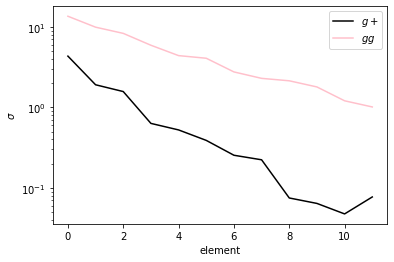

In [6]:
#### covariance matrix
# this is fairly simple - it's a Ntheta*3 x Ntheta*3 square array
# the examples I've given here have analytic covariances, but they could just as easily be jackknife

C = f['covmat'].read()
print(C.shape)

## the ordering is wgp, wpp, wgg
D = np.sqrt(np.diag(C))
dwgp = D[:12]
dwgg = D[12:]

plt.plot(dwgp, color='k',label='$g+$')
plt.plot(dwgg, color='pink', label='$gg$')

plt.legend()

plt.yscale('log')
plt.ylabel('$\sigma$')
plt.xlabel('element')

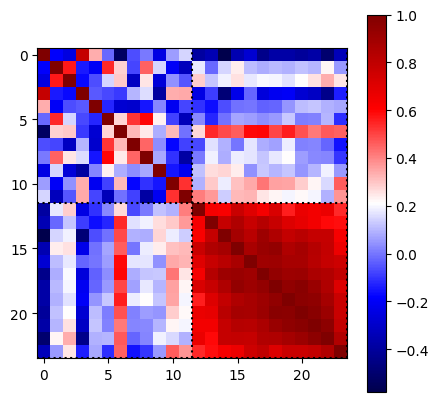

In [7]:
# here's the correlation matrix as well
fig = plt.figure(figsize=(5,5), dpi= 100, facecolor='w', edgecolor='k')
a,b = np.meshgrid(D,D)
corr = C/a/b

plt.imshow(corr,cmap='seismic',interpolation='none')
plt.colorbar()
plt.axhline(11.5,color='k',ls=':')
plt.axhline(23.5,color='k',ls=':')
plt.axvline(11.5,color='k',ls=':')
plt.axvline(23.5,color='k',ls=':')

In [8]:
print(f['covmat'].read_header())


XTENSION= 'IMAGE'              / IMAGE extension
BITPIX  =                  -64 / number of bits per data pixel
NAXIS   =                    2 / number of data axes
NAXIS1  =                   24 / length of data axis 1
NAXIS2  =                   24 / length of data axis 2
PCOUNT  =                    0 / required keyword; must = 0
GCOUNT  =                    1 / required keyword; must = 1
EXTNAME = 'COVMAT'             / 
STRT_0  =                    0 / 
STRT_1  =                   12 / 
STRT_2  =                   24 / 
NAME_0  = 'wgp'                / 
NAME_1  = 'wgg'                / 


In [9]:
### correlation functions

info_wgp = f['wgp'].read() # galaxy-shape
info_wgg = f['wgg'].read() # galaxy-galaxy

# should be the same for all three 2pt correlations
# the units are Mpc/h
rp = info_wgp['SEP'] 

# column names again
print(info_wgp.dtype.names)


('SEP', 'SEPBIN', 'VALUE', 'BIN1', 'BIN2', 'SAMPLE1', 'SAMPLE2')


In [10]:
# there's not that much in the header for the correlation functions atm
print(f['wgp'].read_header())


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                   56 / width of table in bytes
NAXIS2  =                   12 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                    7 / number of fields in each row
TTYPE1  = 'SEP'                / label for field   1
TFORM1  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE2  = 'SEPBIN'             / label for field   2
TFORM2  = 'K'                  / data format of field: 8-byte INTEGER
TTYPE3  = 'VALUE'              / label for field   3
TFORM3  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE4  = 'BIN1'               / label for field   4
TFORM4  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE5  = 'BIN2'               / label for fiel

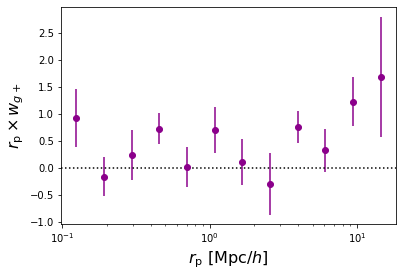

In [11]:
# plot, for example, wgp
plt.errorbar(rp,rp*info_wgp['VALUE'], yerr=rp*dwgp, linestyle='none', color='darkmagenta', marker='o')

plt.xlabel(r'$r_{\rm p}$ [Mpc/$h$]', fontsize=16)
plt.ylabel(r'$r_{\rm p} \times w_{g+}$', fontsize=16)
plt.xscale('log')
plt.axhline(0,color='k',ls=':')

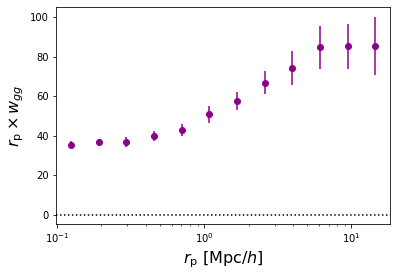

In [12]:
# wgg
plt.errorbar(rp,rp*info_wgg['VALUE'], yerr=rp*dwgg, linestyle='none', color='darkmagenta', marker='o')

plt.xlabel(r'$r_{\rm p}$ [Mpc/$h$]', fontsize=16)
plt.ylabel(r'$r_{\rm p} \times w_{gg}$', fontsize=16)
plt.xscale('log')
plt.axhline(0,color='k',ls=':')